<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab03_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Linear and Logistic Regression
### Author: Szymon Nowakowski


# Introduction
------------------------

In this lab, we will explore **linear regression** and **logistic regression**, two foundational techniques in **supervised learning**, a type of machine learning where models learn to map input features to specific target labels based on labeled examples.

Supervised learning contrasts with **unsupervised learning**, such as clustering, where the data has no predefined labels, and the goal is to discover hidden patterns or groupings. In supervised learning, however, the goal is clear: the model learns from labeled data to predict outcomes for new, unseen data. For example:
- In **regression** tasks, the target variable is continuous, such as predicting house prices based on square footage and location.
- In **classification** tasks, the target variable is categorical, such as determining whether a patient has a disease based on medical test results.

**Linear regression** is the simplest form of supervised learning for regression problems. It predicts a continuous target variable by fitting a straight line that best explains the relationship between input features and the target.

**Logistic regression**, while sharing similarities with linear regression, is designed for classification problems. Instead of predicting a continuous value, it models the probability of a data point belonging to a particular class using a sigmoid function, which outputs values between 0 and 1.

By learning from labeled examples, supervised learning mimics how humans often learn with guidance. For instance, a child might be shown pictures of animals and told which ones are dogs and cats, eventually learning to classify new animals correctly. In this lab, we will leverage similar principles to build and evaluate models for both regression and classification tasks.


## Linear Regression Model and Objective

In linear regression, we assume a Gaussian noise relationship between features $x_i$ and the continuous response $y_i$. Specifically, we model:

$$
y_i \sim \mathcal{N}(x_i^\top \beta, \sigma^2),
$$

where the conditional log-likelihood of $\beta$ given our dataset $\{(x_i, y_i)\}$ is proportional to the negative sum of squared errors.

Since this model is fully observed—without hidden latent variables—maximizing the log-likelihood is equivalent to minimizing the sum of squared residuals:

$$
\sum_i \left(y_i - x_i^\top \beta\right)^2.
$$

Unlike Gaussian mixtures (where latent cluster assignments and the ELBO are introduced), linear regression optimizes the likelihood directly via ordinary least squares (OLS). **Hence, no ELBO is needed.**



## Logistic Regression Model and Objective

In logistic regression, each binary label $y_i \in \{0, 1\}$ is modeled as being generated from a Bernoulli distribution. The Bernoulli parameter is the logistic sigmoid function applied to a linear combination of the features:

$$
y_i \sim \text{Bernoulli}\left(\sigma(x_i^\top \beta)\right),
$$

where the logistic sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

This results in a log-likelihood corresponding to the logistic (cross-entropy) loss, which remains fully tractable as no latent variables are introduced. Each $y_i$ is observed, allowing us to optimize the negative log-likelihood:

$$
-\sum_{i=1}^N \left[ y_i \log(\sigma(x_i^\top \beta)) + (1 - y_i) \log(1 - \sigma(x_i^\top \beta)) \right].
$$

This optimization can be performed directly via gradient ascent or equivalent methods. We will see how Iterated Reweighted Least Squares ( asecond-order method) can iteratively be used to optimize the objective.

**Due to the complete data specification, there is no need for an ELBO mechanism, as seen in latent-variable models.**


# Linear Regression
-------------------

## Working example - computer processor performance

We will use `cpus` dataset which comes from the `MASS` R package. Therefore we need to download this R package into Python. It is perfectly possible.

In [ ]:

# Import required libraries
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri

# Activate the pandas-R interface
pandas2ri.activate()

# Load the cpus dataset from the MASS package in R
r('install.packages("MASS", repos="http://cran.us.r-project.org")')
r('library(MASS)')
cpus_df = r('as.data.frame(cpus)')




(as ‘lib’ is unspecified)







	‘/tmp/RtmpRB3cvH/downloaded_packages’



In [ ]:
# Display the dataset
print("CPU Dataset Loaded from R:")
print(cpus_df.head())

# Drop the first and last columns (processor name and estimated performance)
cpus_df = cpus_df.iloc[:, 1:-1]

CPU Dataset Loaded from R:
             name  syct  mmin   mmax  cach  chmin  chmax  perf  estperf
1   ADVISOR 32/60   125   256   6000   256     16    128   198      199
2   AMDAHL 470V/7    29  8000  32000    32      8     32   269      253
3   AMDAHL 470/7A    29  8000  32000    32      8     32   220      253
4  AMDAHL 470V/7B    29  8000  32000    32      8     32   172      253
5  AMDAHL 470V/7C    29  8000  16000    32      8     16   132      132


In [ ]:
# Data overview
print("\nDataset summary:")
print(cpus_df.describe())


Dataset summary:
              syct          mmin          mmax        cach       chmin  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            chmax         perf  
count  209.000000   209.000000  
mean    18.267943   105.617225  
std     25.997318   160.830587  
min      0.000000     6.000000  
25%      5.000000    27.000000  
50%      8.000000    50.000000  
75%     24.000000   113.000000  
max    176.000000  1150.000000  


## Linear Regression with `sklearn`

`sklearn.linear_model.LinearRegression` does not include built-in diagnostic plots. The `LinearRegression` class in `scikit-learn` is focused solely on fitting models and making predictions, but it does not provide tools for visualization or diagnostic analysis.

However, you can create diagnostic plots **manually** using libraries like `matplotlib`, `seaborn`, or **automatically** with `statsmodels`. We shall show the mixture of those technics in a moment.

First, let's estimate and test a new linear regression model using `sklearn`.

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split dataset into predictors and response variable
X = cpus_df.iloc[:, :-1]  # All columns except the last one
y = cpus_df.iloc[:, -1]   # The last column is the response variable

# Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a linear regression model

model = LinearRegression()
model.fit(X_train, y_train)

# Display coefficients
print("\nModel coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Model coefficients:
syct: 0.0185687855962332
mmin: 0.012670088467355086
mmax: 0.0035221558505683474
cach: 0.7125867924874885
chmin: 3.6518795431475097
chmax: 0.027708662220592206
Intercept: -19.236706185399157

Mean Squared Error (MSE): 14991.786502160634
Root Mean Squared Error (RMSE): 122.4409510832084
R² Score: 0.7381895279320151


## Diagnostic Plots


### Diagnostic Plot Differences: R vs Python

The difference in behavior arises from how **R** and **`statsmodels` (Python)** handle some diagnostic plotting for regression models.




                            OLS Regression Results                            
Dep. Variable:                   perf   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     155.7
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           3.95e-59
Time:                        12:11:58   Log-Likelihood:                -737.60
No. Observations:                 146   AIC:                             1489.
Df Residuals:                     139   BIC:                             1510.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.2367      6.893     -2.791      0.0

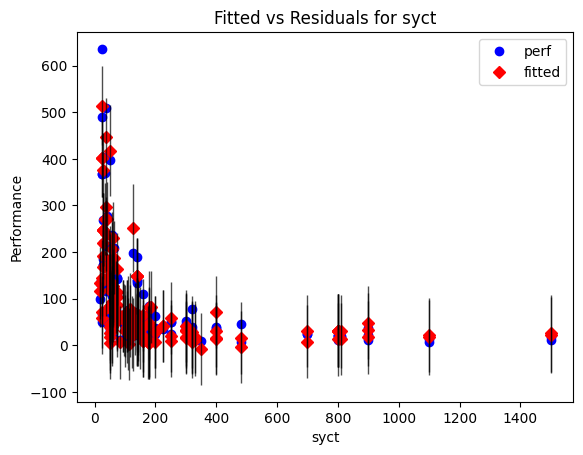

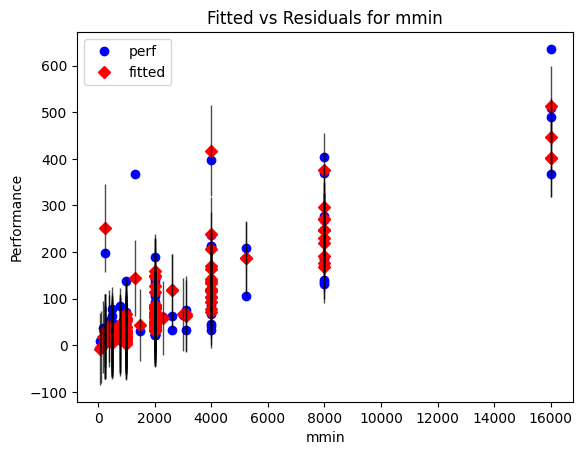

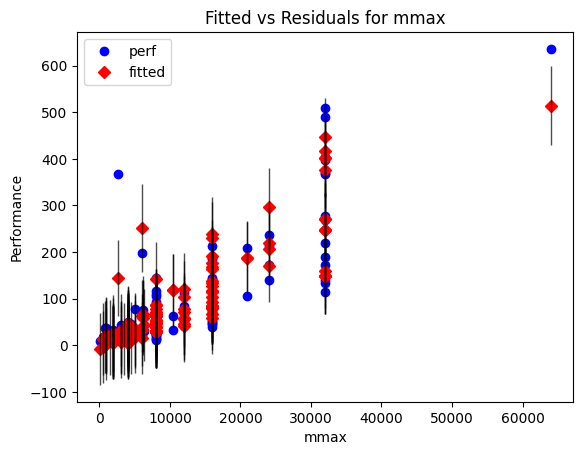

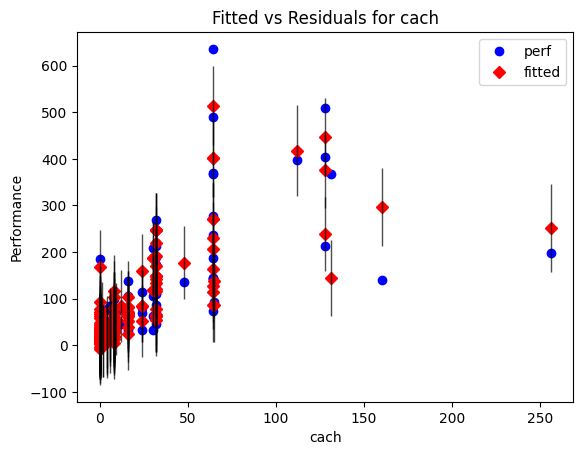

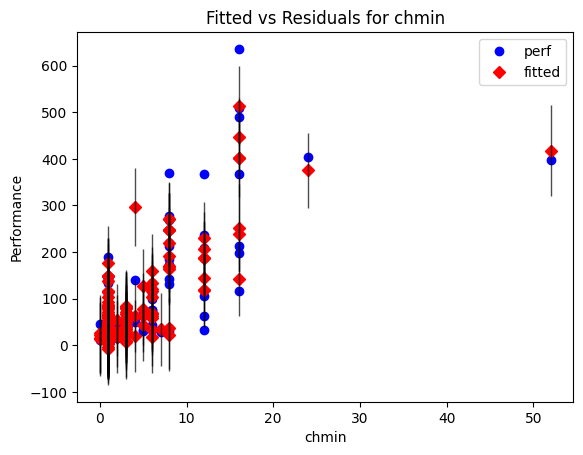

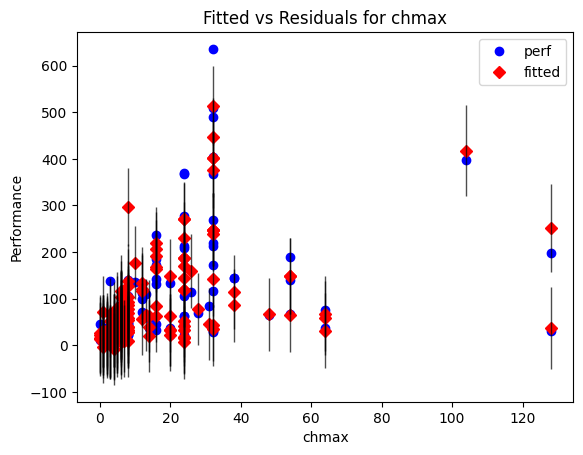

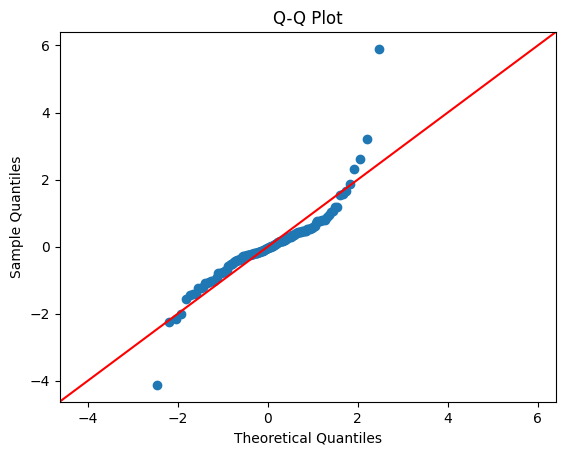

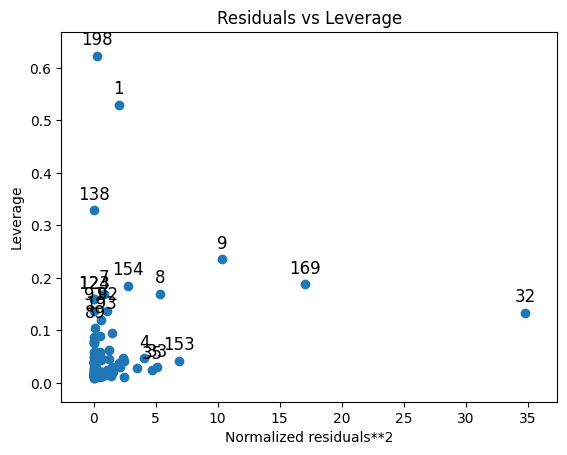

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Add a constant column for intercept (required for statsmodels)
X_train = sm.add_constant(X_train)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Summary of the model
print(model.summary())

# Diagnostic plots
# 1. Residuals vs Fitted
for predictor in X_train.columns[1:]:  # Skip the constant column
    sm.graphics.plot_fit(model, exog_idx=predictor)
    plt.xlabel(predictor)
    plt.ylabel("Performance")
    plt.title(f"Fitted vs Residuals for {predictor}")
    plt.show()

# 2. Q-Q plot for residuals
sm.graphics.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# 3. Residuals vs Leverage
sm.graphics.plot_leverage_resid2(model)
plt.title("Residuals vs Leverage")
plt.show()




### Residuals vs Leverage

The above plot is quite different the the R plot:

<img src="https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/residuals_vs_leverage_in_R.PNG?raw=1" alt="residuals vs levarage plot in R" width="600" height="400">

Note that

- the axes are reversed,
- the standardized residuals are squared in Python and they are not R,
- the Cook's boundaries are included for easier interpretation. You would have to add that manually in Python

### Scale-Location needs to be simulated, too

<img src="https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/scale_vs_location_in_R.PNG?raw=1" alt="scale vs location plot in R" width="600" height="400">

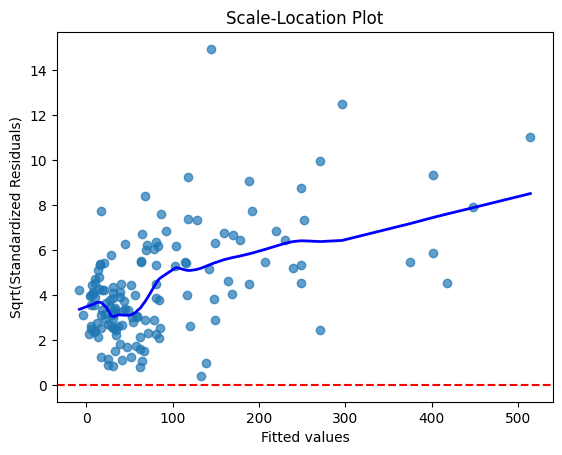

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# 4. Scale-Location Plot
residuals = model.resid
fitted = model.fittedvalues
sqrt_std_residuals = np.sqrt(np.abs(residuals))

# Lowess smoothing for trend line
lowess_smooth = lowess(sqrt_std_residuals, fitted, frac=0.3)  # frac controls the smoothing

plt.scatter(fitted, sqrt_std_residuals, alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--")
plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color="blue", linewidth=2, label="Trend Line (Lowess)")

plt.title("Scale-Location Plot")
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(Standardized Residuals)")
plt.show()



### Residuals vs Fitted
In **R**, diagnostic plot **"Residuals vs Fitted"** is a model-level diagnostics. It relies on the fitted values ($\hat{y}$) and residuals ($y - \hat{y}$), which are properties of the regression model itself. The plot does not depend on specific predictors.

<img src="https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/residuals_vs_fitted_in_R.PNG?raw=1" alt="residuals vs fitted plot in R" width="600" height="400">


#### Python's `sm.graphics.plot_fit`:
In **Python**, the `sm.graphics.plot_fit` function in **statsmodels** is designed specifically to visualize **one predictor variable at a time**. It shows the relationship between the chosen predictor and the fitted values, making it more focused than R's general diagnostic plot.

#### How to Get an R-Like "Residuals vs Fitted" Plot in Python

We can emulate R's behavior and plot Residuals vs Fitted independently of specific predictors with a custom plot.

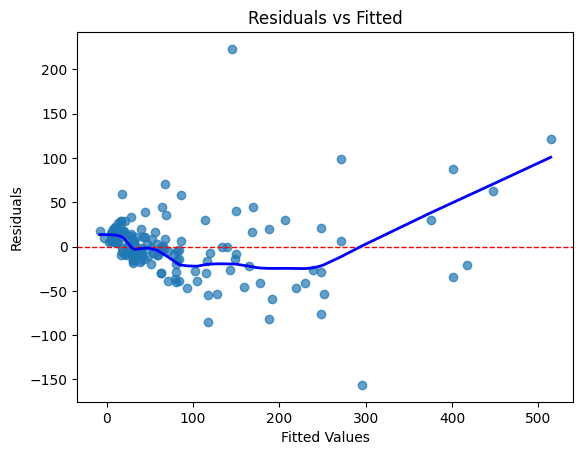

In [ ]:


# Residuals vs Fitted Plot
fitted_values = model.fittedvalues  # Predicted values (fitted values)
residuals = model.resid  # Residuals

# Lowess smoothing for trend line
lowess_smooth = lowess(residuals, fitted_values, frac=0.3)  # frac controls the smoothing

plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)  # Horizontal line at 0
plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color="blue", linewidth=2, label="Trend Line (Lowess)")

plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


## What to Look for in the Charts

The diagnostic plots are essential for diagnosing issues like non-linearity, heteroscedasticity, or influential observations.

### Ideal (Correct) Behavior
1. **Random Scatter Around Zero**:
   - Residuals should be randomly distributed around the horizontal line $y = 0$.
   - This indicates that the model is capturing all patterns in the data, leaving only random noise in the residuals.

2. **No Clear Patterns**:
   - Residuals should not show a trend, curve, or other systematic structure.
   - A lack of patterns suggests that the model adequately describes the relationship between predictors and the target variable.

3. **Homoscedasticity (Constant Variance)**:
   - The spread of residuals should remain constant across all fitted values.
   - Residuals should not fan out or converge, indicating that variance is independent of the fitted values.

### Common Issues (Incorrect Behavior)

1. **Non-Linearity**:
   - **Behavior**: Residuals show a curved pattern.
   - **Interpretation**: The relationship between predictors and the target is non-linear, and the linear model is insufficient.
   - **Fix**: Consider transforming predictors (e.g., polynomial terms) or using a non-linear model.

2. **Heteroscedasticity (Non-Constant Variance)**:
   - **Behavior**: Residuals fan out (increasing spread) or converge (decreasing spread).
   - **Interpretation**: The variance of residuals depends on the fitted values.
   - **Fix**: Use weighted least squares (WLS) or transform the dependent variable.

3. **Outliers or Influential Points**:
   - **Behavior**: Individual points far away from the horizontal line $y = 0$ or with high leverage.
   - **Interpretation**: Certain observations have undue influence on the regression model.
   - **Fix**: Investigate and potentially remove or transform these points.

4. **Systematic Pattern**:
   - **Behavior**: A pattern in residuals, such as waves or clustering.
   - **Interpretation**: The model is missing important features or interactions.
   - **Fix**: Add missing predictors or interaction terms.


### Example Plots

1. Correct Behavior
- **Description**: Residuals are randomly scattered around zero, with no discernible patterns or variance issues.
- **What It Means**: The model fits the data well and captures the underlying relationship.

```
Residuals
|
|    .  .         .   .  
|   .        .    .        
|       .     .       .    
| .   .   .       .         
|_______________________ Fitted
```

2. Non-Linearity
- **Description**: A curved pattern in the residuals.
- **What It Means**: The relationship is non-linear, and the model is insufficient.

```
Residuals
|
|    .  .          
|       .   .     
|          .   
|   .    .   .    
|_______________________ Fitted
         (curve)
```

3. Heteroscedasticity
- **Description**: Residuals fan out or narrow as fitted values increase.
- **What It Means**: Variance is not constant, violating an assumption of linear regression.

```
Residuals
|
| .   .  
|  .     .  
|   .       .    
|    .          .    
|_______________________ Fitted
```

4. Outliers or Influential Points
- **Description**: Points far away from $y = 0$ or with extreme fitted values.
- **What It Means**: Certain data points have a disproportionate influence on the model.

```
Residuals
|
|  .  .            
|   .              
|         .      (outlier)
|       .          .       
|_______________________ Fitted
```




### How to Fix Issues

1. **Non-Linearity**:
   - Add polynomial terms (e.g., $x^2$) or interactions to the model.
   - Use non-linear regression techniques.

2. **Heteroscedasticity**:
   - Transform the dependent variable (e.g., log or square root).
   - Use weighted least squares (WLS).

3. **Outliers or Influential Points**:
   - Use diagnostic tools like **Cook's Distance** to identify influential points.
   - Remove or adjust these points if they are errors or anomalies.

4. **Systematic Patterns**:
   - Add missing predictors, interactions, or non-linear transformations.


## Nonlinear Transformations with Linear Regression Models

In a James Bond movie, there’s a memorable scene where a young woman, water skiing, passes by James Bond as he relaxes on a terrace with a martini glass. She splashes him with water and exclaims, "Oh my God, I made you all wet!" To which Bond coolly replies, "Yes, but my martini is still dry."

This is because the terms *wet* and *dry* refer to somewhat different contexts.

Similarly, in regression, even when we apply nonlinear transformations to variables, the model remains linear. This is because the term *linear* refers specifically to the relationship between the response variable and the predictors (transformed or not).

As a result of analyzing the diagnostic charts, we conclude that the response variable appears to increase exponentially. Additional support for this observation comes from [Moore's Law](https://pl.wikipedia.org/wiki/Prawo_Moore%E2%80%99a), which states that various parameters of computer systems (including processor performance) double every 24 months—indicating exponential growth. Therefore, we will attempt to use a (nonlinear) logarithmic transformation for the response variable, `perf`, to bring it to a linear scale.

Formally, we will now apply a linear regression model to the nonlinearly transformed variable `log(perf)`.

**Note:** Other nonlinear transformations can be applied to both the response variable and the predictors, particularly if they are justified by the phenomenon being modeled. For example, if we are modeling the `volume` of a cylinder, we might conclude that the `volume` is a linear function not of the base `radius`, but of the square of the base `radius`. In this case, we would use a (nonlinear) square function for the predictor `radius`.

We have two options to achieve this:

1. Apply a logarith function to the column in a dataframe and *after that* proceed excactly as before (create a model, create diagnostic charts)

2. Using the *Formula API* in `statsmodels`: Similar to R, `statsmodels` provides a formula interface that supports transformations directly within the regression formula. You do not need to manually transform the data first. It is usefull for quick modelling.

We will proceed the second way.


                            OLS Regression Results                            
Dep. Variable:           np.log(perf)   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     93.14
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           3.23e-46
Time:                        12:12:01   Log-Likelihood:                -84.276
No. Observations:                 146   AIC:                             182.6
Df Residuals:                     139   BIC:                             203.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3046      0.079     42.086      0.0

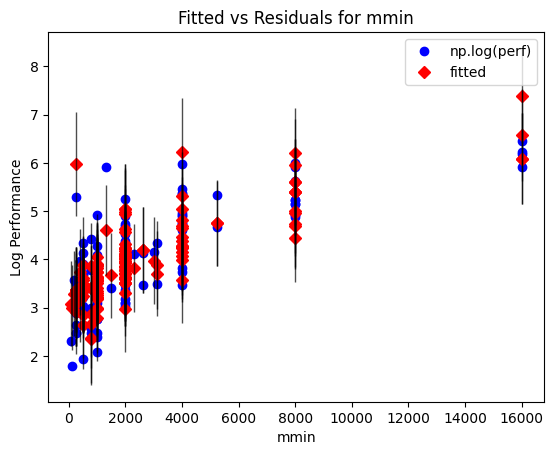

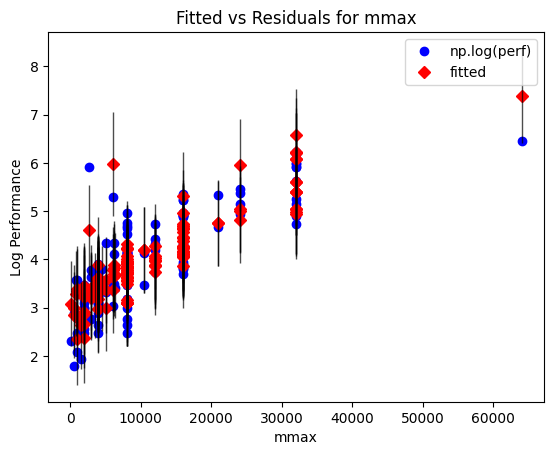

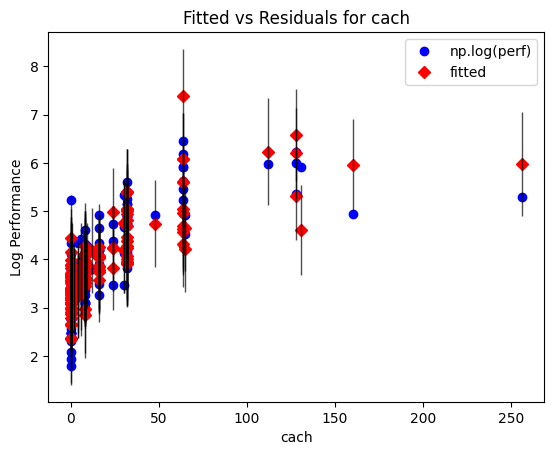

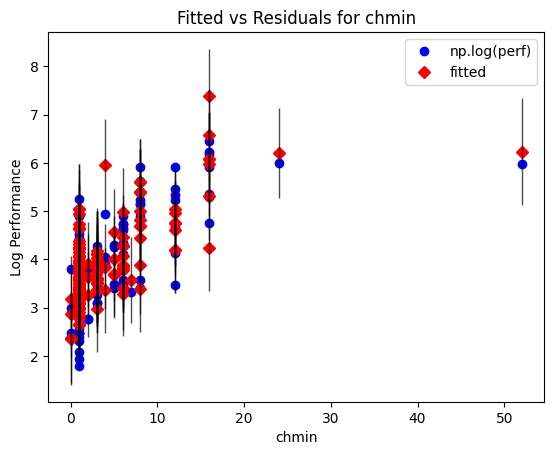

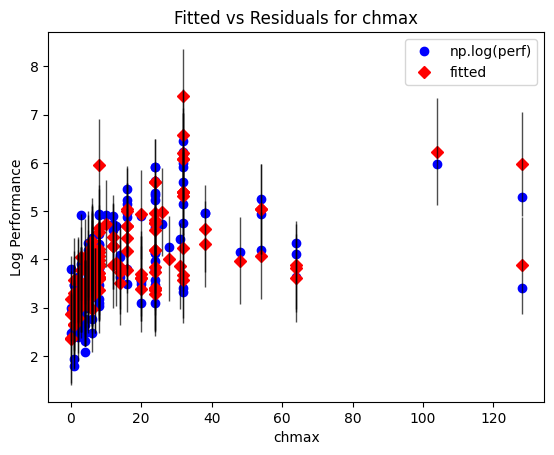

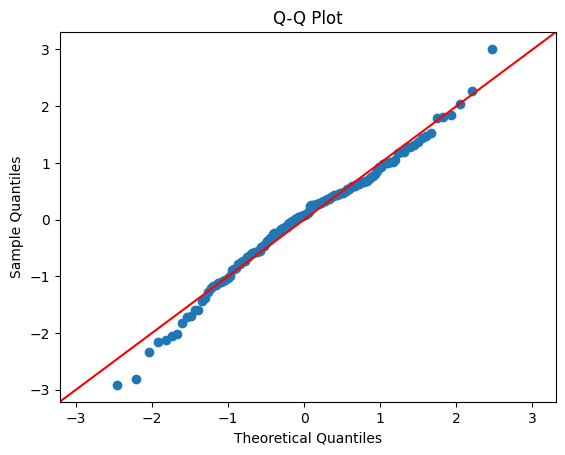

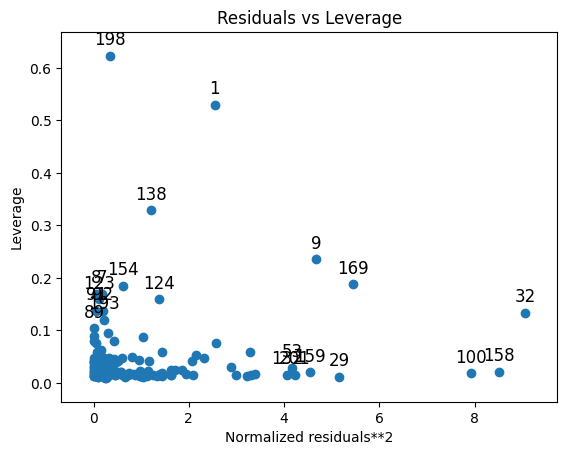

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(cpus_df, test_size=0.3, random_state=42)



# Fit the model using statsmodels formula API with a log transformation on 'perf'
model = sm.OLS.from_formula('np.log(perf) ~ chmax + chmin + cach + mmax + mmin + syct + 1', data=train_df).fit()
# Note, that adding a constant column for intercept is not needed now, we will add that explicitly in a formula

# Summary of the model
print(model.summary())

# Diagnostic plots
# 1. Residuals vs Fitted
for predictor in train_df.columns[1:-1]:  # Iterate over predictors, skip the constant and perf itself
    sm.graphics.plot_fit(model, exog_idx=predictor)
    plt.xlabel(predictor)
    plt.ylabel("Log Performance")
    plt.title(f"Fitted vs Residuals for {predictor}")
    plt.show()

# 2. Q-Q plot for residuals
sm.graphics.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# 3. Residuals vs Leverage
sm.graphics.plot_leverage_resid2(model)
plt.title("Residuals vs Leverage")
plt.show()

### Box-Cox Transform

Another popular transformation is the Box-Cox transformation, where for a certain parameter $\lambda$, we apply the transformation:
$$
Y_i \rightarrow \frac{Y_i^\lambda - 1}{\lambda}
$$
for the response. It can be used on the predictor, too

For $\lambda = 0$ a limit $\lambda \rightarrow 0$ is used which is a logarithmic transformation. The parameter $\lambda$ is chosen to make the distribution of residuals as close as possible to a normal distribution.



#### **Interpreting $\lambda$**

The $\lambda$ value determines the nature of the transformation:

- $\lambda = 1$: No transformation (original data is used).
- $\lambda = 0$: Log transformation is applied ($\log(y)$).
- $-1 < \lambda < 1$: Partial transformation for skewness reduction.
- $\lambda < 0$: Reciprocal transformation, which is rarely used but may apply in some cases.

Finding the Box-Cox transform for cach
Optimal λ (lambda) used for the Box-Cox transformation of cach: -0.00979270408751659
Finding the Box-Cox transform for chmin
Optimal λ (lambda) used for the Box-Cox transformation of chmin: -0.5696061225877678
Finding the Box-Cox transform for chmax
Optimal λ (lambda) used for the Box-Cox transformation of chmax: -0.0074181450764105785
Finding the Box-Cox transform for mmax
Optimal λ (lambda) used for the Box-Cox transformation of mmax: 0.2324068977371931
Finding the Box-Cox transform for mmin
Optimal λ (lambda) used for the Box-Cox transformation of mmin: 0.039473154290203386
Finding the Box-Cox transform for syct
Optimal λ (lambda) used for the Box-Cox transformation of syct: -0.16753844148423974
                            OLS Regression Results                            
Dep. Variable:           np.log(perf)   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.828
Method:         

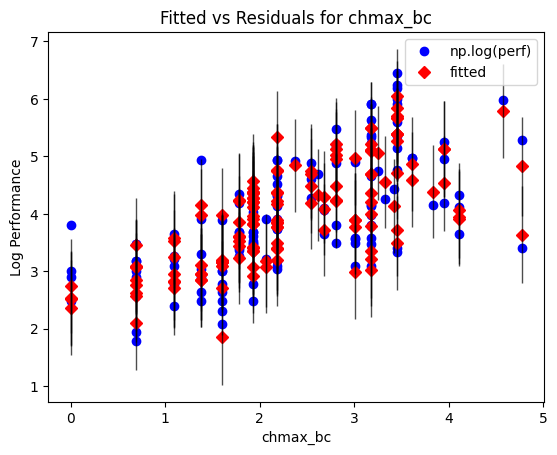

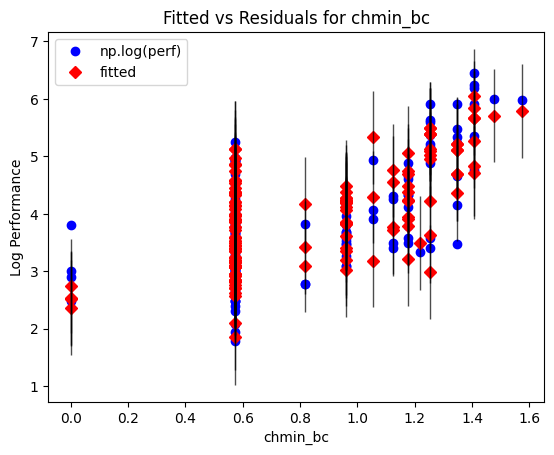

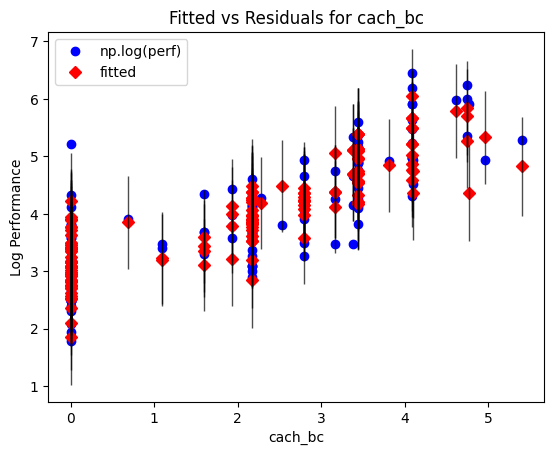

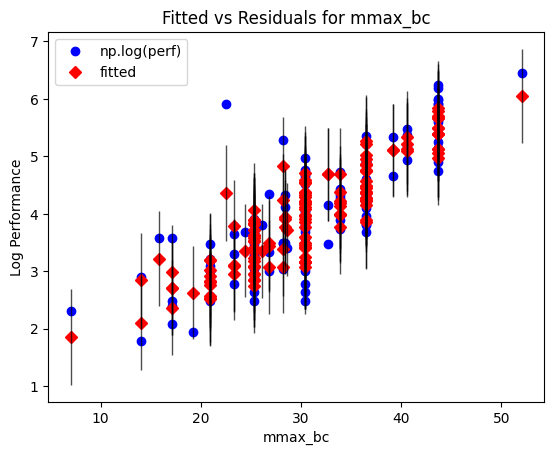

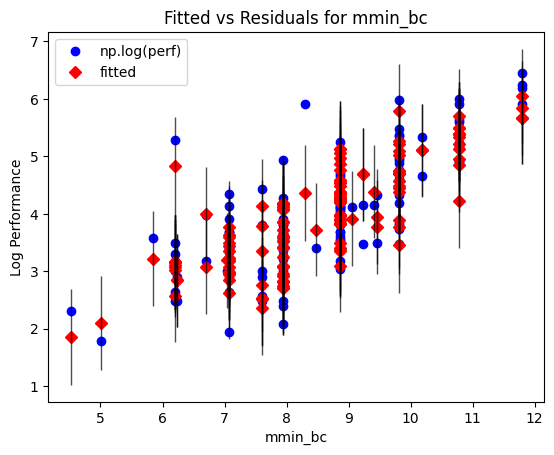

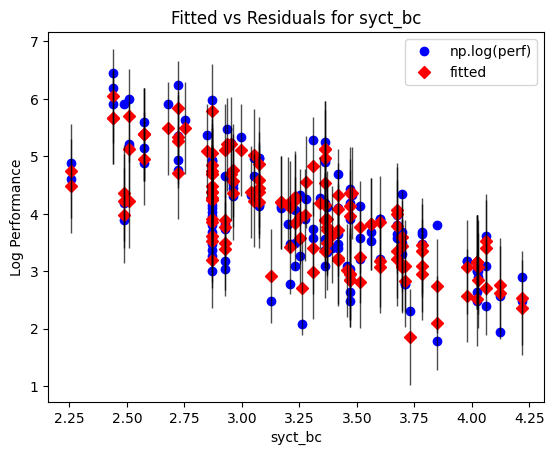

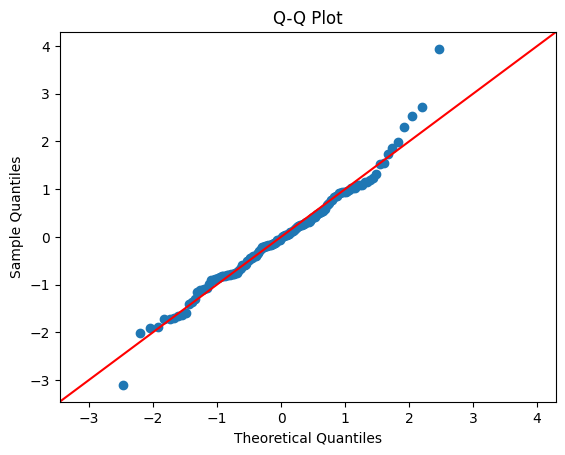

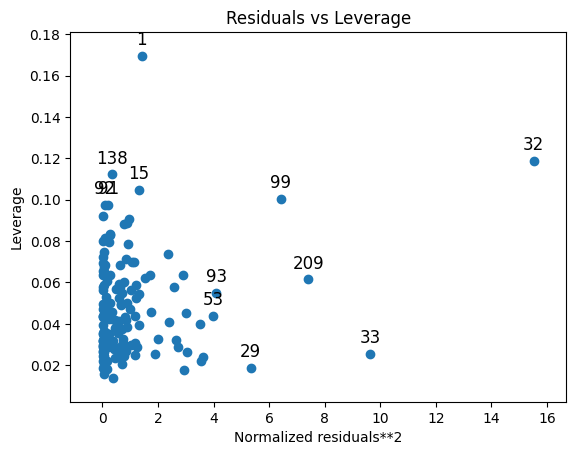

In [ ]:
from scipy.stats import boxcox

# Apply Box-Cox transformation to predictors
lambdas = {}  # Store lambda values for each predictor
for column in ['cach', 'chmin', 'chmax', 'mmax', 'mmin', 'syct']:
    print(f"Finding the Box-Cox transform for {column}")
    train_df[column + '_bc'], lambdas[column] = boxcox(train_df[column]+(1 if column in ['cach', 'chmin', 'chmax'] else 0))
    # Output the lambda value
    print(f"Optimal λ (lambda) used for the Box-Cox transformation of {column}: {lambdas[column]}")

# Fit the model with the transformed predictors
formula = 'np.log(perf) ~ chmax_bc + chmin_bc + cach_bc + mmax_bc + mmin_bc + syct_bc + 1'
# Note, that adding a constant column for intercept is not needed now, we will add that explicitly in a formula
boxcox_model = sm.OLS.from_formula(formula, data=train_df).fit()

# Summary of the model
print(boxcox_model.summary())

# Diagnostic plots
# Residuals vs Fitted
for column in ['chmax_bc', 'chmin_bc', 'cach_bc', 'mmax_bc', 'mmin_bc', 'syct_bc']:  # Iterate over transformed predictors
    sm.graphics.plot_fit(boxcox_model, exog_idx=column)
    plt.xlabel(column)
    plt.ylabel("Log Performance")
    plt.title(f"Fitted vs Residuals for {column}")
    plt.show()

# Q-Q plot for residuals
sm.graphics.qqplot(boxcox_model.resid, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# Residuals vs Leverage
sm.graphics.plot_leverage_resid2(boxcox_model)
plt.title("Residuals vs Leverage")
plt.show()


## Removing Predictors from a Model

Since each coefficient $\hat{\beta}_i$ is estimated, but the true (unknown) value of the coefficient is $\beta_i$, we can ask whether this true value (although unknown) might actually be zero. In other words, does the given predictor have **any influence on the response variable**?

Recall, the model equation can be stated as:
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p + \epsilon
$$
where $\epsilon$ represents the error term and $\beta_i=0$ represent predictors with **no influence on the response**.

This question leads us to the problem of testing the null hypothesis:
$$
H_0: \beta_i = 0
$$
under the alternative (two-sided) hypothesis:
$$
H_1: \beta_i \neq 0.
$$

Since the distribution of the estimator $\hat{\beta}_i$ is known (it follows a Student's t-distribution with a mean of $\beta_i$), `statsmodels` automatically calculates the p-value for testing these hypotheses. The column `Pr(>|t|)` in the model summary contains these values.

This leads us to dropping the `chmin_bc` and `syct_bc` variables.

                            OLS Regression Results                            
Dep. Variable:           np.log(perf)   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     174.9
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           1.28e-53
Time:                        12:12:05   Log-Likelihood:                -71.718
No. Observations:                 146   AIC:                             153.4
Df Residuals:                     141   BIC:                             168.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6507      0.227      2.866      0.0

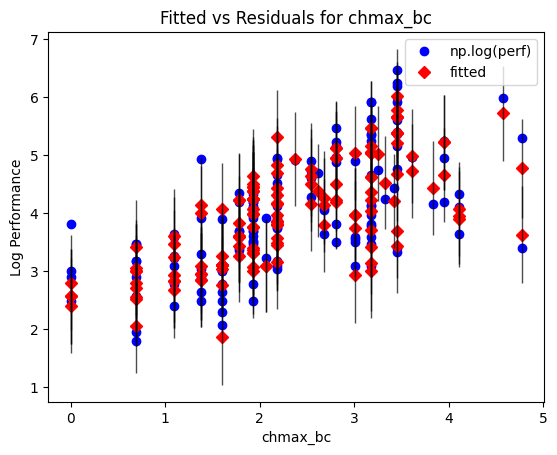

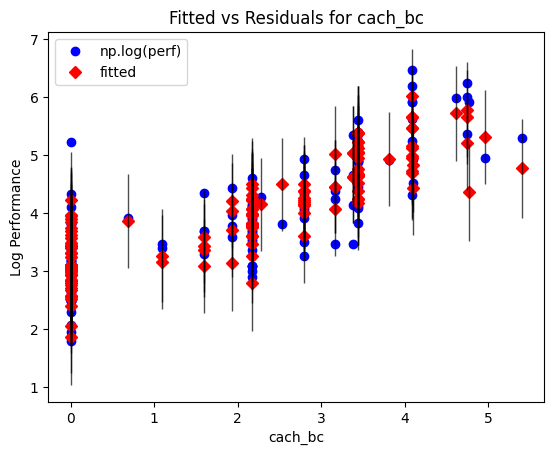

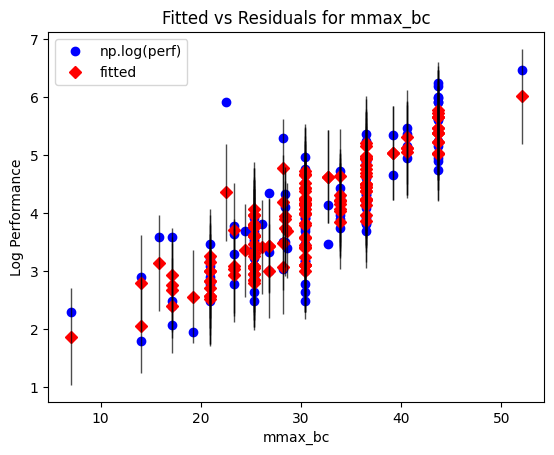

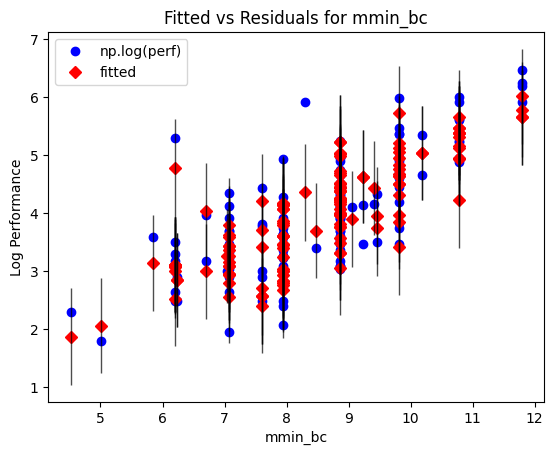

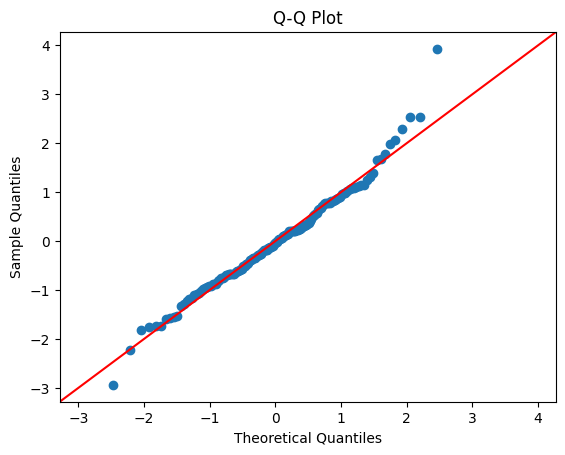

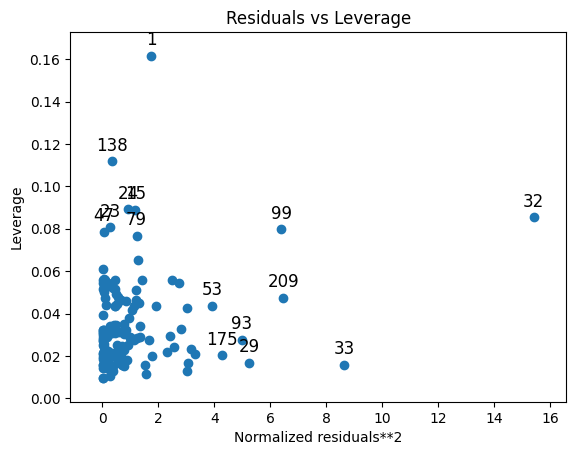

In [ ]:
# Fit the model with the transformed predictors
formula = 'np.log(perf) ~ chmax_bc + cach_bc + mmax_bc + mmin_bc + 1'
# Note, that adding a constant column for intercept is not needed now, we will add that explicitly in a formula
boxcox_model = sm.OLS.from_formula(formula, data=train_df).fit()

# Summary of the model
print(boxcox_model.summary())

# Diagnostic plots
# Residuals vs Fitted
for column in ['chmax_bc', 'cach_bc', 'mmax_bc', 'mmin_bc']:  # Iterate over transformed predictors
    sm.graphics.plot_fit(boxcox_model, exog_idx=column)
    plt.xlabel(column)
    plt.ylabel("Log Performance")
    plt.title(f"Fitted vs Residuals for {column}")
    plt.show()

# Q-Q plot for residuals
sm.graphics.qqplot(boxcox_model.resid, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# Residuals vs Leverage
sm.graphics.plot_leverage_resid2(boxcox_model)
plt.title("Residuals vs Leverage")
plt.show()


# Logistic Regression
--------------------------------



## Comparing Logistic Regression with Linear Regression

**Objective:** Highlight why logistic regression is better suited for classification tasks.

**Experiment:**
Use the same dataset to fit both linear regression and logistic regression. **Beware** that the logistic regression is by default penalized in `scikit-learn`.

We will show how linear regression produces inappropriate probabilities (e.g., negative or >1) and plot predictions for both methods to compare.

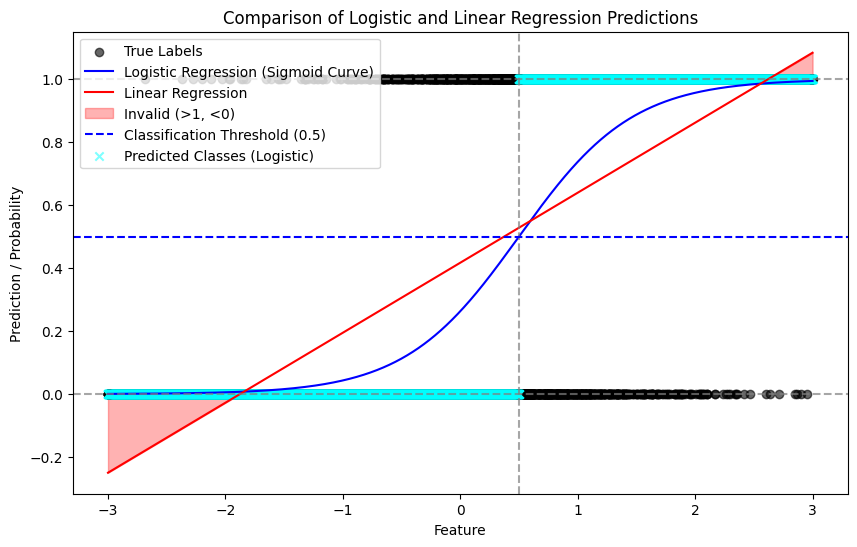

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error

# Generate synthetic data based on the ideal logistic model
np.random.seed(42)

# Define coefficients for the logistic model
beta_0 = -1  # Intercept
beta_1 = 2   # Slope

# Generate the feature values (X)
X = np.linspace(-3, 3, 10000).reshape(-1, 1)

# Calculate probabilities using the logistic function
logit = beta_0 + beta_1 * X.flatten()
probabilities = 1 / (1 + np.exp(-logit))

# Sample 0-1 values based on the probabilities
y = np.random.binomial(1, probabilities)

# Fit Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X, y)
logistic_preds = logistic_model.predict_proba(X)[:, 1]  # Probabilities for class 1
predicted_classes_logistic = logistic_model.predict(X)  # Predicted classes (0 or 1)

# Fit Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_preds = linear_model.predict(X)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', label='True Labels', alpha=0.6)
plt.plot(X, logistic_preds, color='blue', label='Logistic Regression (Sigmoid Curve)')
plt.plot(X, linear_preds, color='red', label='Linear Regression')

# Highlight inappropriate probabilities
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(1, color='gray', linestyle='--', alpha=0.7)
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.7)
plt.fill_between(X.flatten(), linear_preds.flatten(), 1, where=(linear_preds > 1), color='red', alpha=0.3, label='Invalid (>1, <0)')
plt.fill_between(X.flatten(), linear_preds.flatten(), 0, where=(linear_preds < 0), color='red', alpha=0.3, label=None)

# Add classification threshold information
threshold = 0.5  # Default threshold for logistic regression
plt.axhline(threshold, color='blue', linestyle='--', label='Classification Threshold (0.5)')
plt.scatter(X, predicted_classes_logistic, color='cyan', label='Predicted Classes (Logistic)', alpha=0.5, marker='x')

plt.title("Comparison of Logistic and Linear Regression Predictions")
plt.xlabel("Feature")
plt.ylabel("Prediction / Probability")
plt.legend()
plt.show()





## What about the intersection point?

The blue curve (logistic regression sigmoid) and the red curve (linear regression line) do not necessarily intersect with the blue dashed line (classification threshold) at the same point due to their fundamentally different modeling approaches. Furthermore, if logistic regression were merely a sigmoid transformation of the linear regression model, the linear regression line would rather cross 0.0 exactly where the sigmoid crosses 0.5, which is also **not the case**.

### Logistic Regression:

- Models the log-odds (logarithm of the odds of the event happening) as a linear combination of features:  
$$
\text{logit}(p) = \beta_0 + \beta_1 X
$$

- Maps the log-odds to a probability using the sigmoid function:  
$$
p = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}
$$

- The sigmoid function introduces non-linearity, creating the characteristic S-shape. The intersection with the threshold (e.g., $p = 0.5$) occurs at the point where the log-odds equals zero:  
$$
\beta_0 + \beta_1 X = 0
$$

### Linear Regression:

- Models the target variable directly as a linear combination of features:  
$$
y = \beta_0 + \beta_1 X + \epsilon
$$

- Does not account for probabilities or thresholds, and it extends predictions outside the valid range $[0, 1]$ for probabilities.

- The red curve intersects the blue dashed line wherever the linear equation equals the threshold value (e.g., $y = 0.5$), which generally differs from where the logistic regression curve crosses $p = 0.5$.

### Breaking symmetry

**But if the distribution of
$x$ is symmetric, and the data are generated in a balanced way (logistic center at $x=0.5$), shouldn’t the best linear approximation also cross 0.5 at $x=0.5$? Wouldn’t it break symmetry if it shifted left or right?**

Well, the logistic function is centered (in terms of probability = 0.5) at $x=0.5$. But the data is sampled from $[−3,3]$ in a way that is symmetric about $x=0$. These two centers (0.5 vs. 0) do not coincide.


## Iteratively Reweighted Least Square (IRLS)



### **Understanding IRLS**

📚 **See also** → *The Elements of Statistical Learning*:  
Trevor Hastie, Robert Tibshirani, and Jerome Friedman, Springer, 2009.  
[📖 Link to the book](https://hastie.su.domains/ElemStatLearn/)
(Chapter 4.4)


The **IRLS algorithm** solves logistic regression by iteratively updating the coefficients $\beta$. At each iteration, the algorithm performs a weighted least squares regression using the current estimate of probabilities.

#### **The Iterative Process**

At iteration $t$, given current parameter estimate $\beta^{(t)}$, the update to $\beta^{(t+1)}$ is:

$$
\beta^{(t+1)} = \beta^{(t)} + \left( X^\top W^{(t)} X \right)^{-1} X^\top W^{(t)} \left[ y - p^{(t)} \right],
$$

where

$$
p^{(t)} = \sigma\left( X \beta^{(t)} \right)
$$

are the current predicted probabilities (using the logistic sigmoid),

$$
W^{(t)} = \text{diag}\left[ p^{(t)} \odot \left( 1 - p^{(t)} \right) \right]
$$

is the diagonal weight matrix, and $y$ is the vector of binary outcomes.

Equivalently, one often sees the "adjusted response" form:

$$
\beta^{(t+1)} = \left( X^\top W^{(t)} X \right)^{-1} X^\top W^{(t)} z^{(t)},
$$

where

$$
z^{(t)} = X \beta^{(t)} + \left( W^{(t)} \right)^{-1} \left( y - p^{(t)} \right).
$$


#### **Linear Regression as the First IRLS Iteration**

A common story is:

- Start IRLS by setting $\beta^{(0)} = 0$ (or all parameters to zero).
- Then set $p^{(0)} = 0.5$ for all samples (because $\sigma(0) = 0.5$).
- Hence $W^{(0)} = \text{diag}(0.25, 0.25, \dots)$.

The claim you sometimes hear is that "with constant weights, the first update is just OLS." However:


Even with constant weights $W^{(0)} = 0.25I$, the working response $z^{(0)}$ is not simply $y$, but:

$$
z^{(0)} = X\beta^{(0)} + \left(W^{(0)}\right)^{-1}(y - p^{(0)}) = 0 + 4(y - 0.5) = 4(y - 0.5).
$$

Therefore, the first update becomes:

$$
\beta^{(1)} = \left(X^\top 0.25 X\right)^{-1} X^\top (0.25)[4(y - 0.5)],
$$

which simplifies to:

$$
\beta^{(1)} = 4\left(X^\top X\right)^{-1} X^\top [(y - 0.5)].
$$

This is generally not the same as the ordinary least squares solution:

$$
\beta_{\text{OLS}} = \left(X^\top X\right)^{-1} X^\top y.
$$

In particular, notice two key differences compared to OLS:
1. You have $(y - 0.5)$ in place of $y$.
2. You have an extra scalar factor of $4$.



Iteration 1: diff = 0.9486571583775122
Iteration 2: diff = 0.6149826672127754
Iteration 3: diff = 0.48663848799230075
Iteration 4: diff = 0.23021789788985603
Iteration 5: diff = 0.03669320355302497
Iteration 6: diff = 0.0007708670014816258
Iteration 7: diff = 3.3067707419864105e-07
Iteration 8: diff = 5.937897876935817e-14
Performed 8 iterations.


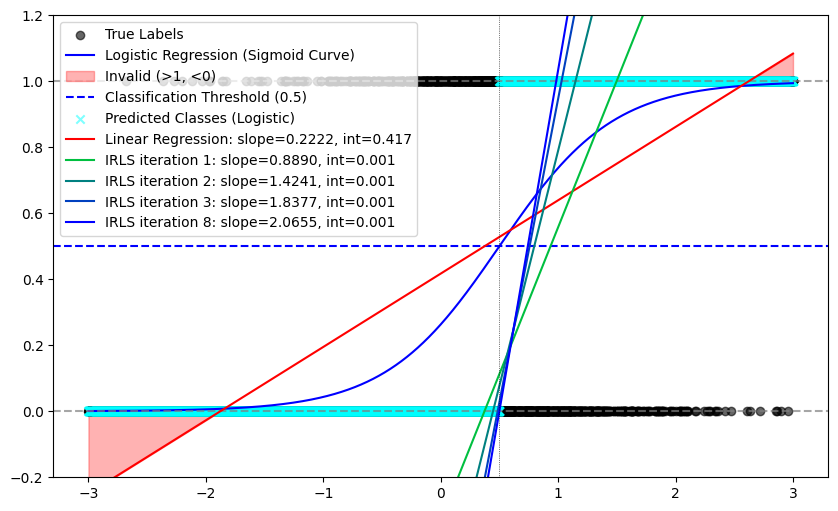

In [ ]:

# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', label='True Labels', alpha=0.6)
plt.plot(X, logistic_preds, color='blue', label='Logistic Regression (Sigmoid Curve)')

# Highlight inappropriate probabilities
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(1, color='gray', linestyle='--', alpha=0.7)
plt.fill_between(X.flatten(), linear_preds.flatten(), 1, where=(linear_preds > 1), color='red', alpha=0.3, label='Invalid (>1, <0)')
plt.fill_between(X.flatten(), linear_preds.flatten(), 0, where=(linear_preds < 0), color='red', alpha=0.3, label=None)

# Add classification threshold information
threshold = 0.5  # Default threshold for logistic regression
plt.axhline(threshold, color='blue', linestyle='--', label='Classification Threshold (0.5)')
plt.scatter(X, predicted_classes_logistic, color='cyan', label='Predicted Classes (Logistic)', alpha=0.5, marker='x')

plt.plot(
    X,
    linear_preds,
    color='red',
    label=f'Linear Regression: slope={linear_model.coef_[0]:.4f}, int={linear_model.intercept_:.3f}'
)




# -----------------------
# IRLS Implementation
# -----------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 1) Prepare the initial guess: set all betas to 0
params_current = np.array([0, 0])
all_params = []

# 2) Build a design matrix [1, x].
X_design = np.hstack([np.ones((X.shape[0], 1)), X])  # shape (n, 2)

# 3) IRLS loop until consecutive parameter update is < 1e-7
while True:
    # Current linear predictor
    z_current = X_design @ params_current

    # Current sigmoid
    p = sigmoid(z_current)

    # Diagonal weights: w_i = p_i * (1 - p_i)
    # (Need to avoid zero weights in dividing, often you can clip p in practice,
    #  but for clarity, we'll keep it simple.)
    W = p * (1 - p)

    # Adjusted response: z_i = z_current_i + (y_i - p_i) / w_i
    # In code, use safe fraction for p*(1-p) if desired, here we assume no perfect 0 or 1.
    z = z_current + (y - p) / W

    # Weighted least squares update:
    # new_params = (X^T W X)^(-1) X^T W z
    W_mat = np.diag(W)               # shape (n, n)
    XTW = X_design.T @ W_mat         # shape (2, n)
    XTWX = XTW @ X_design            # shape (2, 2)
    XTWz = XTW @ z                   # shape (2, )
    new_params = np.linalg.inv(XTWX) @ XTWz

    # Check convergence
    diff = np.linalg.norm(new_params - params_current)
    all_params.append(new_params)
    print(f'Iteration {len(all_params)}: diff = {diff}')
    params_current = new_params

    if diff < 1e-7:
        break

print(f'Performed {len(all_params)} iterations.')
# At this point, all_params[0] is iteration-1 (one after the 0-based start),
# and all_params[-1] is the final IRLS solution.


# 5) Show the straight lines in selected IRLS iterations

selected_indices=[0,1,2,7]
num_lines = len(selected_indices)

for i_line, irls_idx in enumerate(selected_indices, start=1):
    # fraction from 1..4 => color goes from near-red to blue
    frac = i_line / num_lines  # 1/4 to 4/4
    # simple linear interpolation from red=(1,0,0) to blue=(0,0,1)
    color_i = (0, 1 - frac, frac)

    p_ = all_params[irls_idx]
    # Build a grid for plotting the straight line
    x_plot = np.linspace(X.min(), X.max(), 200)
    y_plot = p_[0] + p_[1] * x_plot

    plt.plot(
        x_plot,
        y_plot,
        color=color_i,
        label=f'IRLS iteration {irls_idx + 1}: slope={p_[1]:.4f}, int={p[0]:.3f}'  # shows the real iteration number
    )


# 5) Add a very thin dotted black vertical line where the final IRLS line crosses 0.
#    For y = b + w*x = 0 => x = -b/w, if w != 0.
final_index = len(all_params) - 1
final_params = all_params[final_index]

b_final, w_final = final_params[0], final_params[1]
if abs(w_final) > 1e-14:
    x_decision = -b_final / w_final
    plt.axvline(x_decision, color='black', linestyle=':', linewidth=0.5)

# 6) Finally, keep y-limits from -0.2 to 1.2
plt.ylim(-0.2, 1.2)

# 7) Show the legend, so we can distinguish these lines
plt.legend()
plt.show()


# **Homework Assignment: Optimizing the Classification Threshold in Logistic Regression**

-------------------------------

In this assignment, you will explore the concept of **classification thresholds** in **Logistic Regression** and investigate whether the commonly used threshold of **0.5** is always the optimal choice. To complete this assignment, you will need to conduct **additional reading** on **ROC curves** and the **AUC metric**, beyond the materials covered in class.

This exercise focuses on the **importance of threshold selection** and how it impacts model performance based on different evaluation criteria.



## **The Objective**

**Is a 0.5 threshold always the best choice in Logistic Regression?**

- Analyze if the standard threshold of **0.5** always yields the most desirable results in various scenarios.
- Investigate alternative thresholds and how they can improve model performance depending on the problem context.



## **Helper Questions**

1. **Would a different threshold yield better results?**  
   - How does shifting the threshold affect the **trade-off between sensitivity and specificity**?

2. **How do you define "better" results?**  
   - Is **higher specificity** more valuable than **higher sensitivity** in certain contexts? Or maybe the other way around?
   - Does the **best threshold** depend on the task? *(discuss cases like disease detection vs. spam filtering)*

3. **How does a ROC curve help in this process?**  
   - Learn how to use a **ROC curve** to visualize the trade-off between **True Positive Rate (Sensitivity)** and **False Positive Rate (1 - Specificity)**.

4. **How do you select the optimal threshold using the ROC curve?**  
   - Discuss strategies to select a threshold depending on the specific task at hand and the acceptable **trade-off between sensitivity and specificity**.

5. **What is the AUC metric and how is it useful?**  
   - Define **AUC (Area Under the Curve)** and discuss its role in evaluating the overall performance of a classifier.



## **Tasks & Deliverables**

1. **Colab Notebook**
   - **Divide the dataset into three parts**: **train**, **validation**, and **test**.
   - Train the **Logistic Regression** model on the **training** set.
   - Use the **validation** set to:
     - Plot the **ROC curve**.
     - Calculate the **AUC**.
     - Determine the **optimal threshold** using the ROC curve for your dataset.
   - Apply the selected threshold to the **test** set to evaluate final model performance using metrics like:
     - **Accuracy**
     - **Precision & Recall**
     - **F1-Score**
     - **Specificity & Sensitivity**

2. **Answer the Questions:**
   - Use markdown cells to provide explanations.
   - Answer all helper questions with supporting evidence from your plots and results.

3. **Visualizations:**
   - **ROC curve** based on the **validation** set with threshold points marked.
   - Highlight the **optimal threshold** on the ROC curve.

4. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


